In [1]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def image_to_np_array(image_path):
    return np.asarray(Image.open(image_path).convert("L"))

In [3]:
def plot_image(image_array, title=""):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(image_array, cmap="gray")


def plot_images_side_by_side(images_array, image_names):
    n = len(images_array)
    _, ax = plt.subplots(1, n, figsize=(18, 8))
    for i in range(n):
        ax[i].set_title(image_names[i])
        ax[i].imshow(images_array[i], cmap="gray")
    plt.tight_layout()

In [4]:
def resize_image(image_np_array, shape):
    PIL_image = Image.fromarray(np.uint8(image_np_array)).convert('RGB')
    PIL_image = PIL_image.resize(shape)
    return np.array(PIL_image)

In [5]:
horizontal_derivative = np.zeros((3,3))
horizontal_derivative[1][0] = -1
horizontal_derivative[1][2] = 1

vertical_derivative = np.zeros((3,3))
vertical_derivative[0][1] = -1
vertical_derivative[2][1] = 1

vertical_derivative

array([[ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.]])

In [6]:
def pad_image_with_white(image_np_array, border_size):
    max_row = image_np_array.shape[0]
    max_col = image_np_array.shape[1]
    padded_image = np.ones((max_row + 2*border_size, max_col + 2*border_size), dtype='uint8') * 255
    padded_image[border_size:border_size+max_row, border_size:border_size+max_col] = image_np_array
    return padded_image

def pad_image_with_black(image_np_array, border_size):
    max_row = image_np_array.shape[0]
    max_col = image_np_array.shape[1]
    padded_image = np.zeros((max_row + 2*border_size, max_col + 2*border_size), dtype='uint8')
    padded_image[border_size:border_size+max_row, border_size:border_size+max_col] = image_np_array
    return padded_image

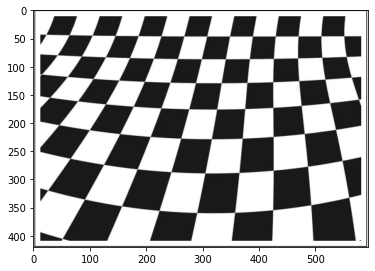

In [7]:
image_array = image_to_np_array("input_image.png")
image_array.shape
plot_image(image_array)

In [8]:
def normalized_image(image_array):
    floor_value = image_array.min()
    ceiling_value = image_array.max()
    scale = (ceiling_value - floor_value) / 255

    return (image_array - floor_value) / scale

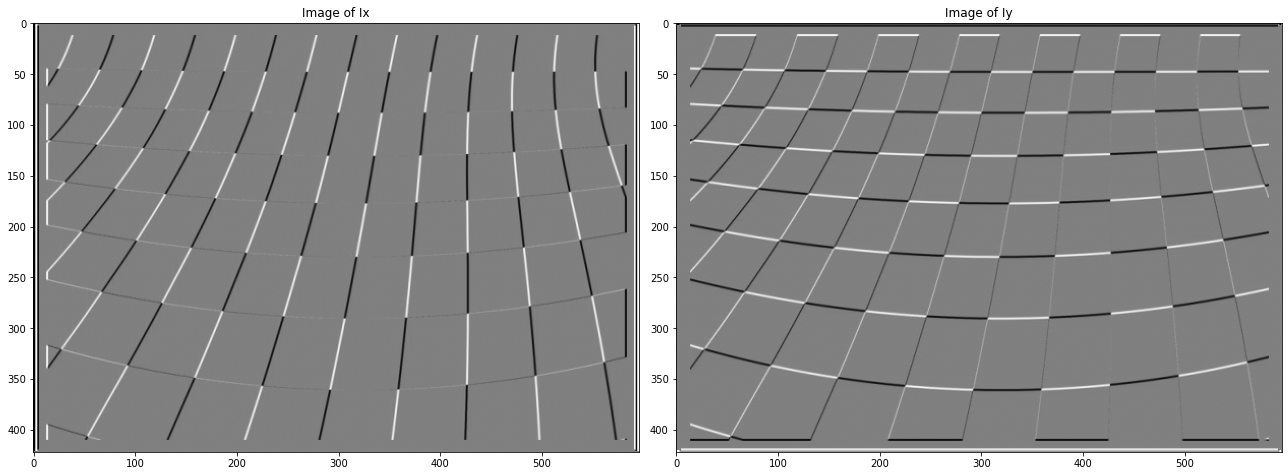

In [9]:
image_ix = signal.convolve2d(image_array, horizontal_derivative)
image_iy = signal.convolve2d(image_array, vertical_derivative)
plot_images_side_by_side([image_ix, image_iy], ["Image of Ix", "Image of Iy"])

In [10]:
image_ix_2 = image_ix * image_ix
image_ix_iy = image_ix * image_iy
image_iy_2 = image_iy * image_iy
box_filter = np.ones((3,3))

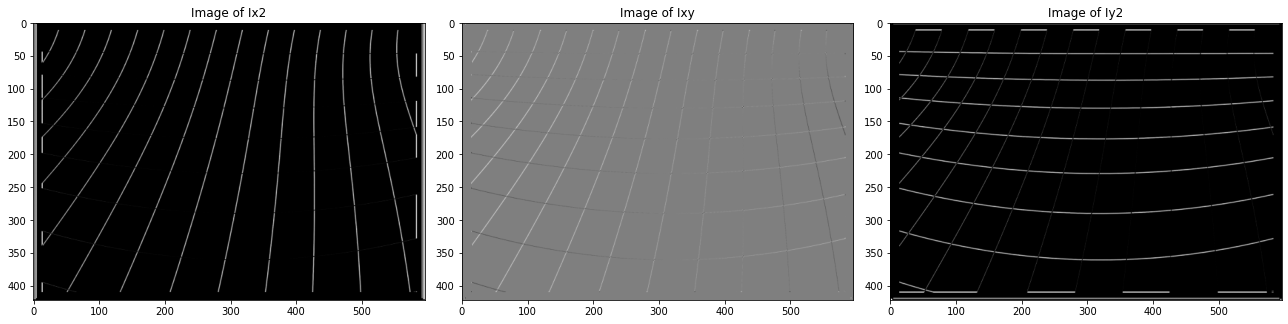

In [13]:
plot_images_side_by_side([image_ix_2, image_ix_iy, image_iy_2], ["Image of Ix2", "Image of Ixy", "Image of Iy2"])

In [14]:
image_aw = signal.convolve2d(image_ix_2, box_filter)
image_bw = signal.convolve2d(image_ix_iy, box_filter)
image_cw = signal.convolve2d(image_iy_2, box_filter)

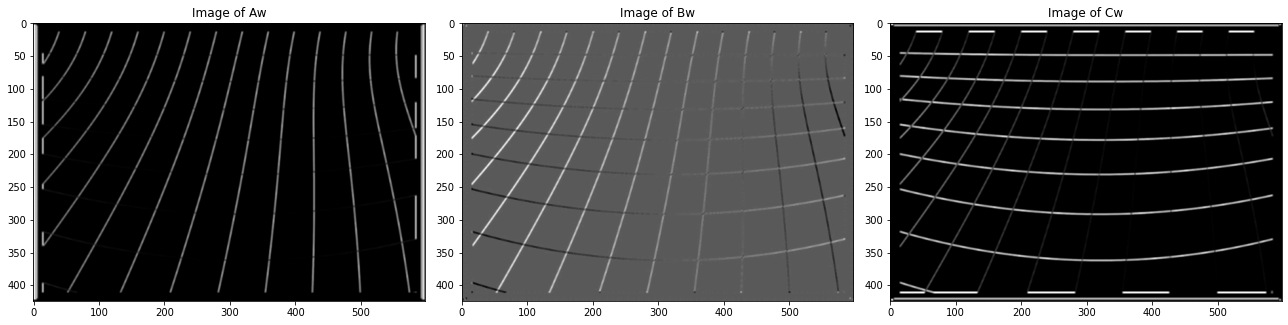

In [15]:
plot_images_side_by_side([image_aw, image_bw, image_cw], ["Image of Aw", "Image of Bw", "Image of Cw"])

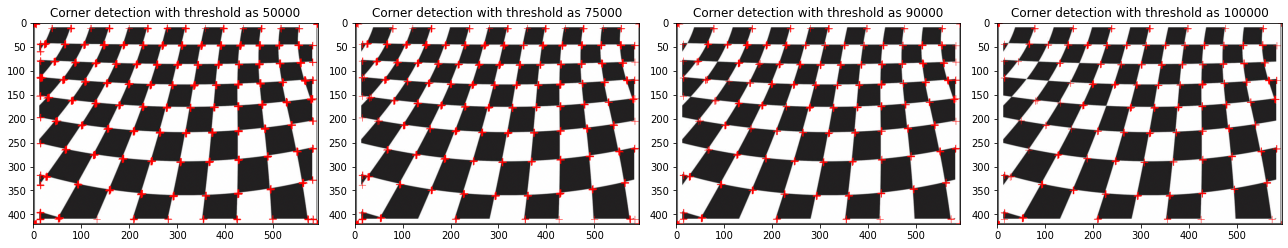

In [16]:
rows, cols = image_aw.shape
experiment_thresholds = [50000, 75000, 90000, 100000]
experiment_images = {threshold: Image.open("input_image.png").convert("RGB") for threshold in experiment_thresholds}
for threshold in experiment_thresholds:
    result_image = experiment_images[threshold]
    draw_result = ImageDraw.Draw(result_image)
    for i in range(rows):
        for j in range(cols):
            matrix = np.array([[image_aw[i][j], image_bw[i][j]], 
                    [image_bw[i][j], image_cw[i][j]]])
            eigenvalues, eigenvectors = np.linalg.eig(matrix)
            min_eigenvalue = min(eigenvalues)
            if min_eigenvalue > threshold:
                draw_result.line(((j-7, i), (j+7, i)), fill = (255, 0, 0))
                draw_result.line(((j, i-7), (j, i+7)), fill = (255, 0, 0))

plot_images_side_by_side([np.asarray(image) for image in experiment_images.values()], 
    [f"Corner detection with threshold as {str(threshold)}" for threshold in experiment_images.keys()])

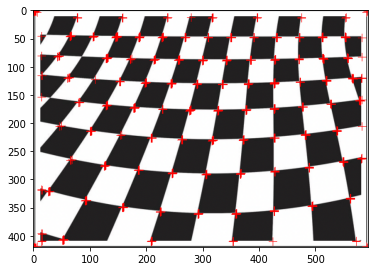

In [21]:
best_image = experiment_images[90000]
best_image.save("corner_detected_image.png")
plot_image(np.asarray(best_image))